<a href="https://colab.research.google.com/github/Aravindh4404/FYPSeagullClassification01/blob/main/Inceptiontry2_HQ2_2111.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install dropblock


Using device: cpu
Mounted at /content/drive
Epoch [1/20], Loss: 0.617095
Validation Accuracy: 80.24%
New best model saved with accuracy: 80.24% at /content/drive/My Drive/FYP/CustomModel/HQ2_20241121_143157/best_model_20241121_143157.pth
Epoch [2/20], Loss: 0.553748
Validation Accuracy: 80.24%
Epoch [3/20], Loss: 0.549279
Validation Accuracy: 80.84%
New best model saved with accuracy: 80.84% at /content/drive/My Drive/FYP/CustomModel/HQ2_20241121_143157/best_model_20241121_143157.pth
Epoch [4/20], Loss: 0.509644
Validation Accuracy: 85.03%
New best model saved with accuracy: 85.03% at /content/drive/My Drive/FYP/CustomModel/HQ2_20241121_143157/best_model_20241121_143157.pth
Epoch [5/20], Loss: 0.437348
Validation Accuracy: 91.62%
New best model saved with accuracy: 91.62% at /content/drive/My Drive/FYP/CustomModel/HQ2_20241121_143157/best_model_20241121_143157.pth
Epoch [6/20], Loss: 0.416921
Validation Accuracy: 85.03%
Epoch [7/20], Loss: 0.396399
Validation Accuracy: 92.81%
New best 

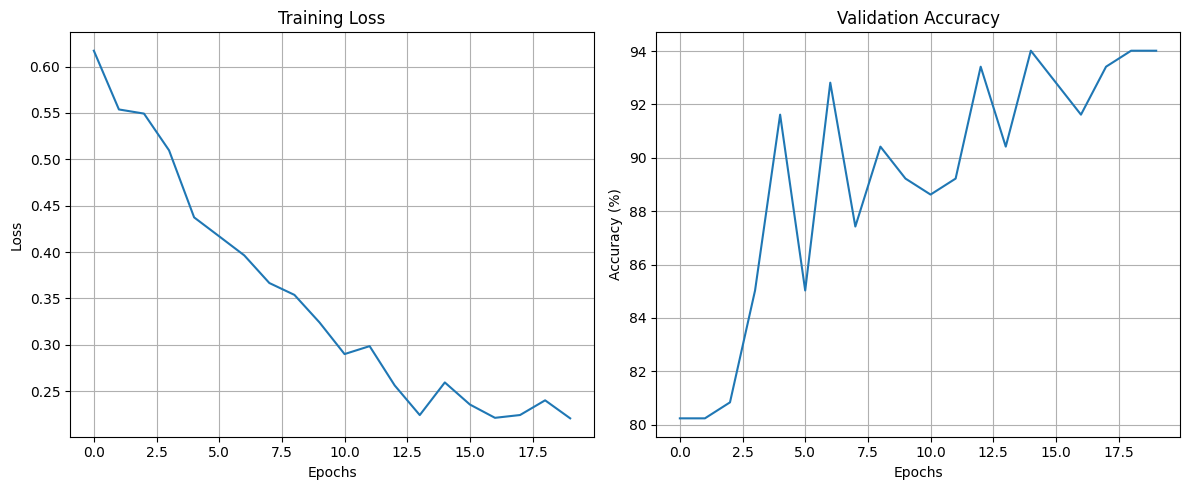

Final model saved at /content/drive/My Drive/FYP/CustomModel/HQ2_20241121_143157/final_model_20241121_143157.pth
Test Accuracy: 77.42%


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import random
import matplotlib.pyplot as plt
from datetime import datetime

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Define the device for computation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Mount Google Drive to save and load the model (if using Google Colab)
from google.colab import drive
drive.mount('/content/drive')

# Define the folder to save model checkpoints
date_str = datetime.now().strftime('%Y%m%d_%H%M%S')
checkpoint_folder = f'/content/drive/My Drive/FYP/CustomModel/HQ2_{date_str}/'
os.makedirs(checkpoint_folder, exist_ok=True)

# Data Augmentation for Training Set
transform_train = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
])

# Simple resizing for validation and test sets
transform_val_test = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Load datasets
data_path = '/content/drive/My Drive/FYP/Dataset/HQ2/train'
test_data_path = '/content/drive/My Drive/FYP/Dataset/HQ2/test'
train_dataset = datasets.ImageFolder(data_path, transform=transform_train)
test_dataset = datasets.ImageFolder(test_data_path, transform=transform_val_test)

# Split the dataset into 80% training and 20% validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define a simple CNN architecture from scratch
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 256),  # Adjust based on input image size
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 2)  # Binary classification
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Initialize the model, loss, optimizer, and scheduler
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3)

# Training loop with checkpointing
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=20):
    best_acc = 0.0
    train_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Print training loss
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {train_loss:.6f}")

        # Validate the model
        val_acc = validate(model, val_loader)
        val_accuracies.append(val_acc)
        scheduler.step(val_acc)

        # Save the best model
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_path = os.path.join(checkpoint_folder, f"best_model_{date_str}.pth")
            torch.save(model.state_dict(), best_model_path)
            print(f"New best model saved with accuracy: {best_acc:.2f}% at {best_model_path}")

    # Plot training and validation metrics
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Validation Accuracy')
    plt.grid(True)

    plt.tight_layout()
    plt.show()
    # Save the final model
    final_model_path = os.path.join(checkpoint_folder, f"final_model_{date_str}.pth")
    torch.save(model.state_dict(), final_model_path)
    print(f"Final model saved at {final_model_path}")
# Validation loop returning accuracy
def validate(model, loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Validation Accuracy: {accuracy:.2f}%')
    return accuracy

# Test function to evaluate on the test set
def test(model, loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

# Step 1: Train the model with learning rate scheduling
train(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=20)

# Step 2: Evaluate the model on the test set
test(model, test_loader)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Processing: /content/drive/My Drive/FYP/Dataset/HQ2/test/Glaucous_Winged_Gull/imageRTEs.jpg


<ipython-input-11-9bf1b57631a0>:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_location=torch.device('cpu')))


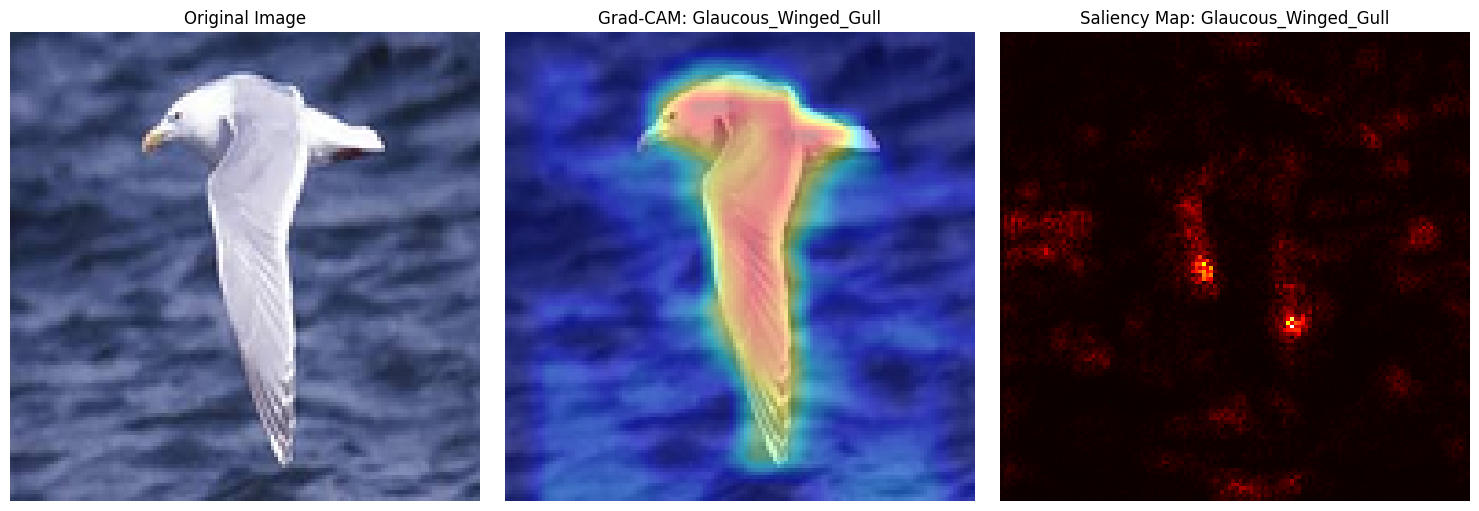

Processing: /content/drive/My Drive/FYP/Dataset/HQ2/test/Glaucous_Winged_Gull/iDFGmages.jpg


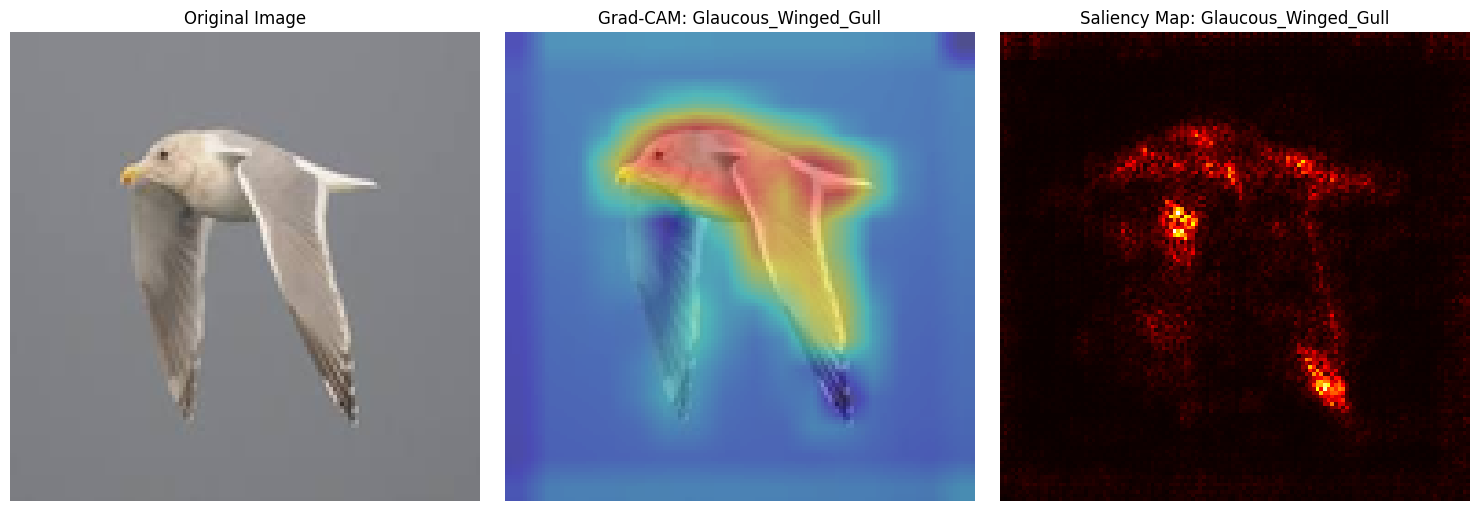

Processing: /content/drive/My Drive/FYP/Dataset/HQ2/test/Glaucous_Winged_Gull/images.jpg


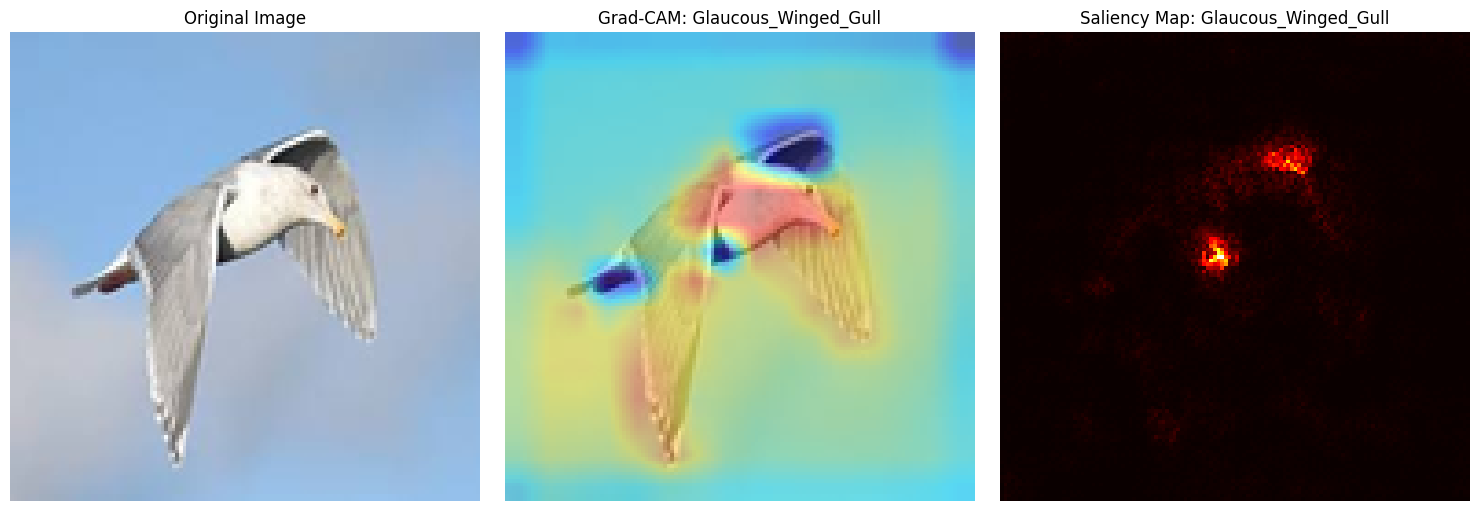

Processing: /content/drive/My Drive/FYP/Dataset/HQ2/test/Glaucous_Winged_Gull/900 - 2024-10-22T213920.718.jpg


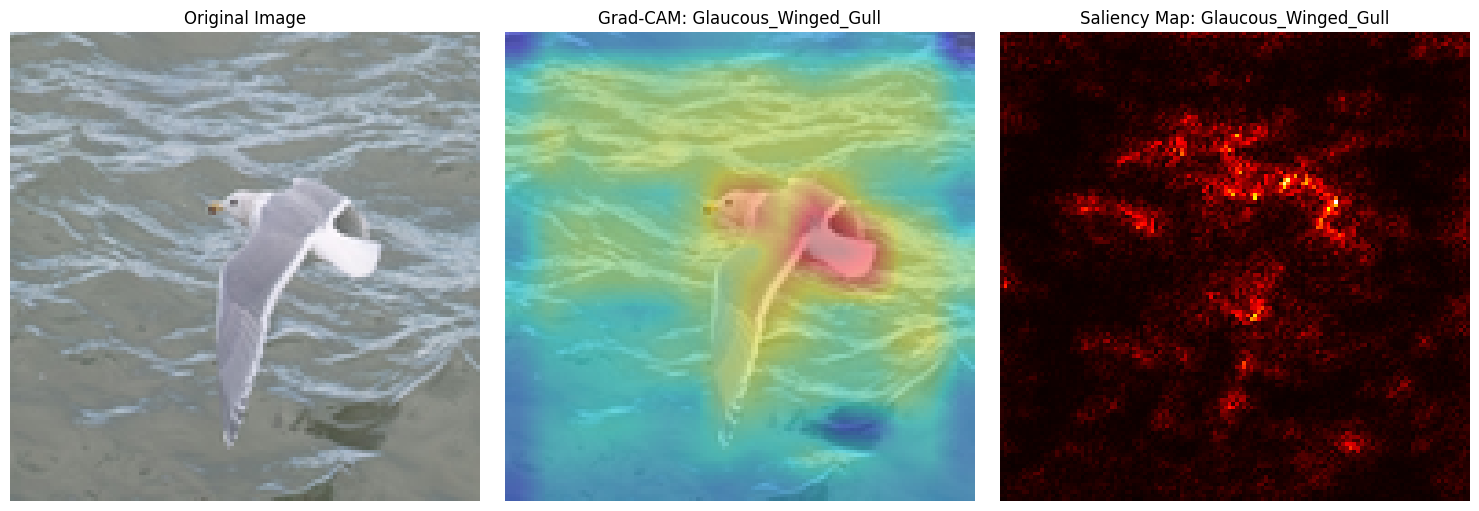

Processing: /content/drive/My Drive/FYP/Dataset/HQ2/test/Glaucous_Winged_Gull/480 (11).jpeg


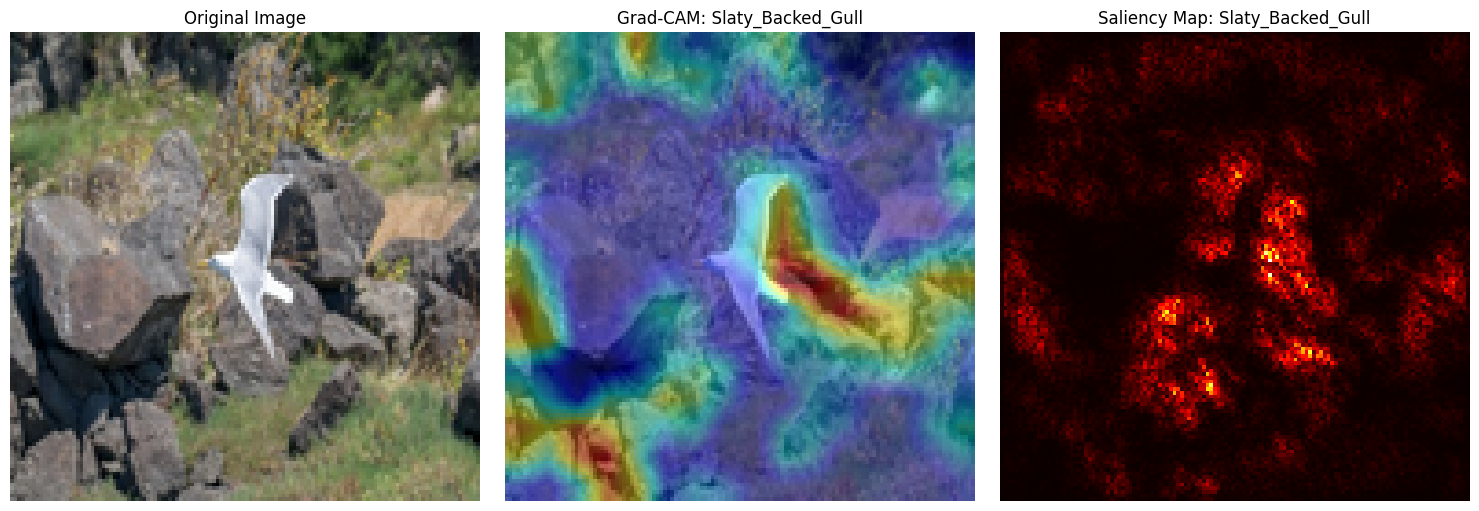

Processing: /content/drive/My Drive/FYP/Dataset/HQ2/test/Glaucous_Winged_Gull/320 (5).jpeg


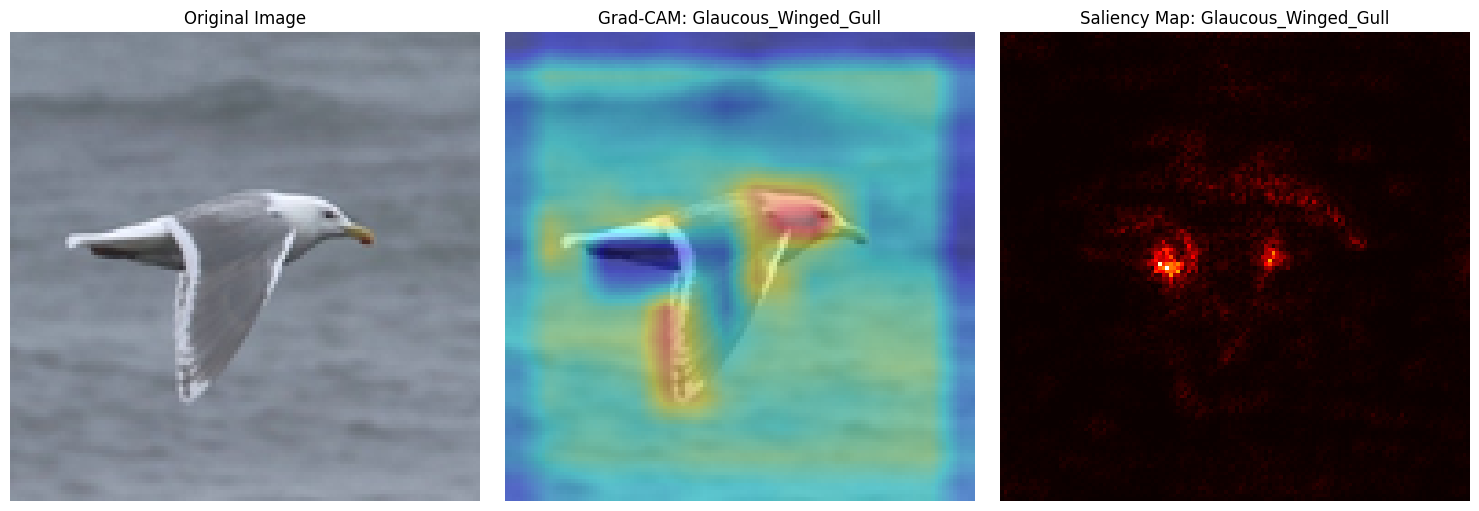

Processing: /content/drive/My Drive/FYP/Dataset/HQ2/test/Slaty_Backed_Gull/480 (14).jpeg


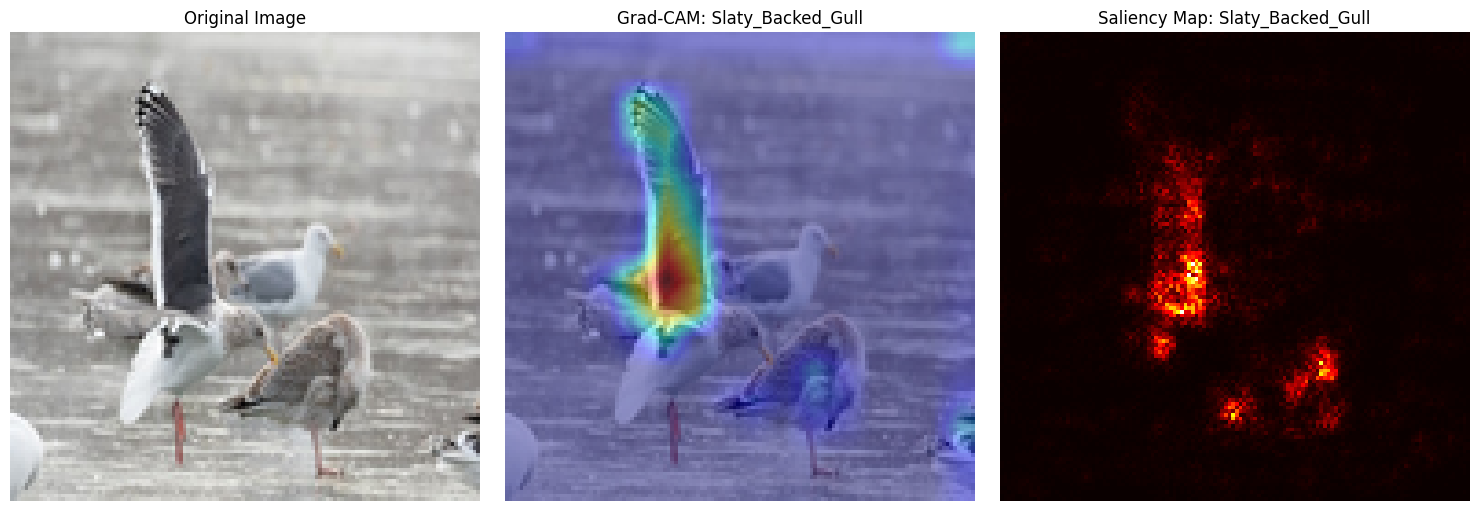

Processing: /content/drive/My Drive/FYP/Dataset/HQ2/test/Slaty_Backed_Gull/480 (34).jpeg


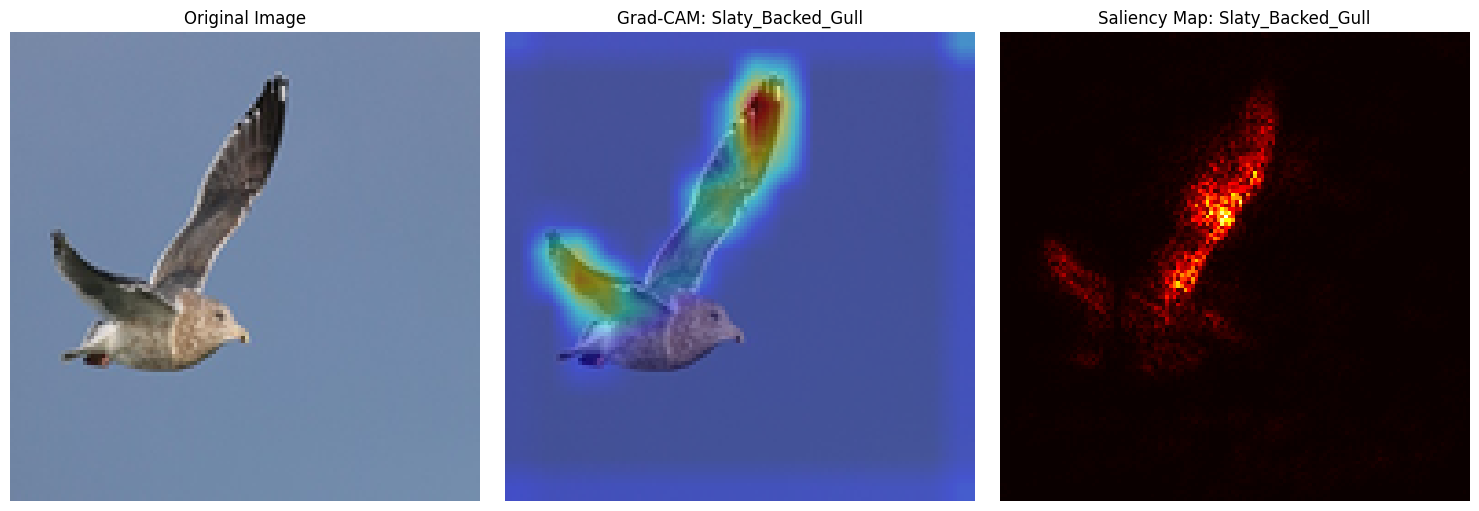

Processing: /content/drive/My Drive/FYP/Dataset/HQ2/test/Slaty_Backed_Gull/480 (42).jpeg


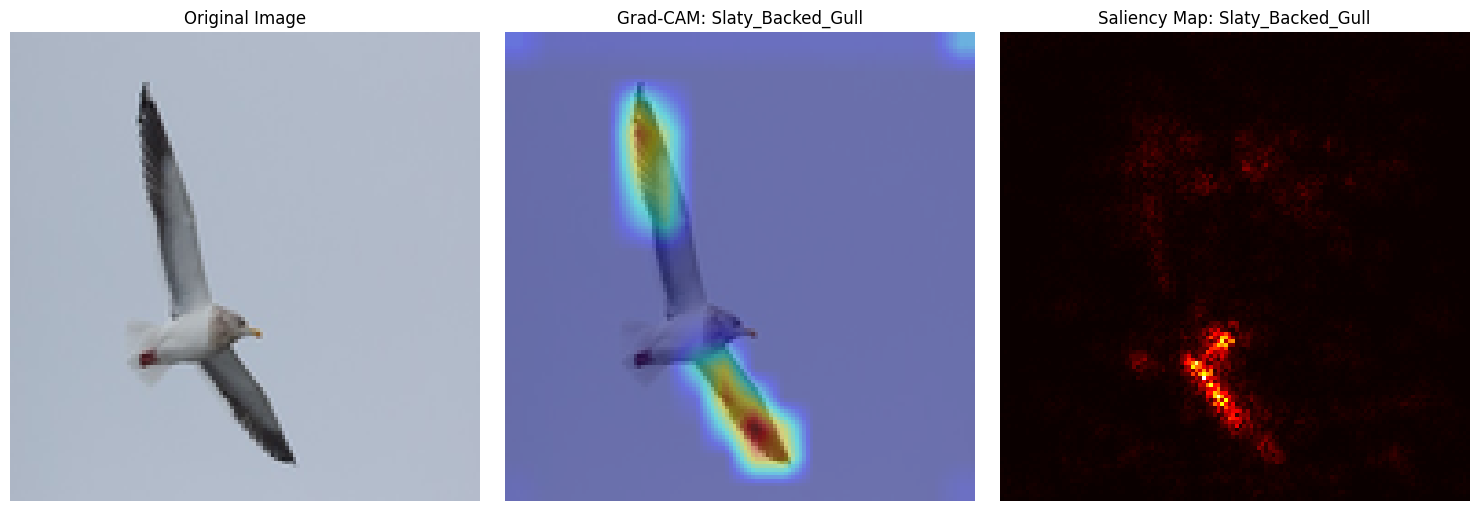

Processing: /content/drive/My Drive/FYP/Dataset/HQ2/test/Slaty_Backed_Gull/480 (52).jpeg


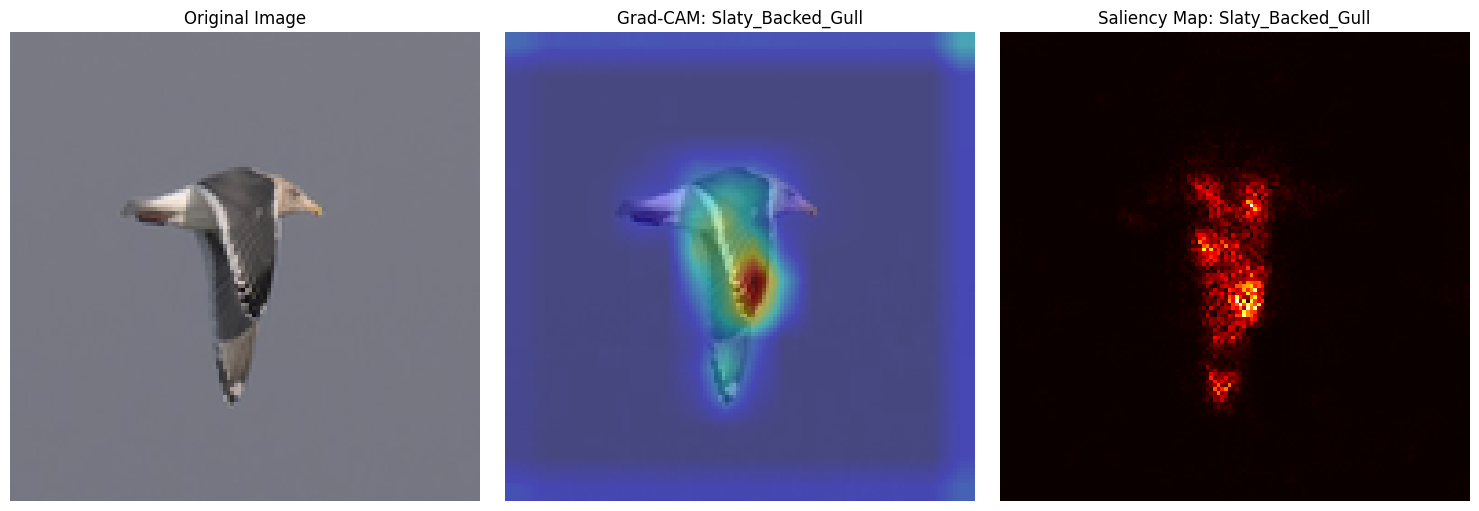

Processing: /content/drive/My Drive/FYP/Dataset/HQ2/test/Slaty_Backed_Gull/480 (10).jpeg


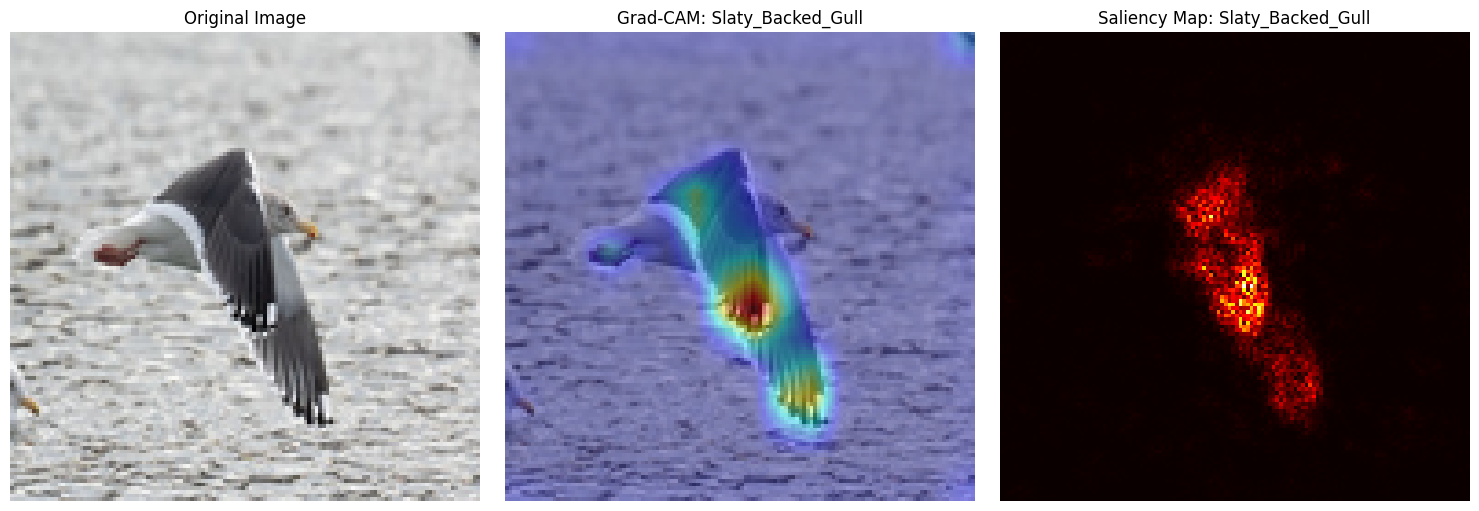

Processing: /content/drive/My Drive/FYP/Dataset/HQ2/test/Slaty_Backed_Gull/480 (28).jpeg


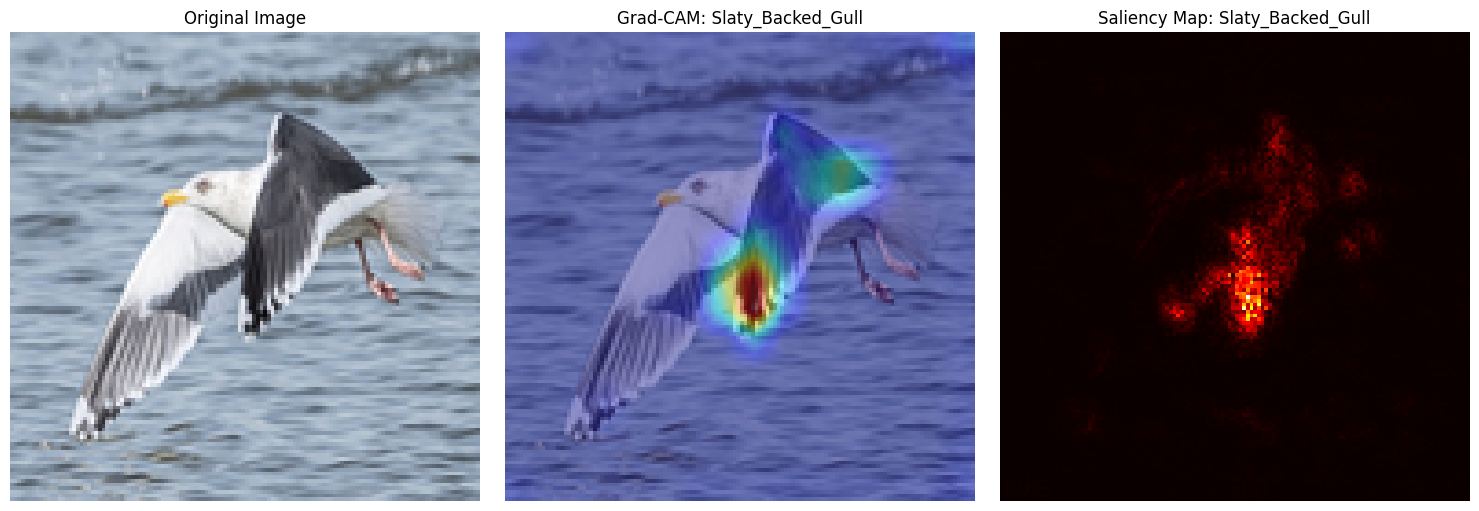

Processing: /content/drive/My Drive/FYP/Dataset/HQ2/test/Slaty_Backed_Gull/480 (49).jpeg


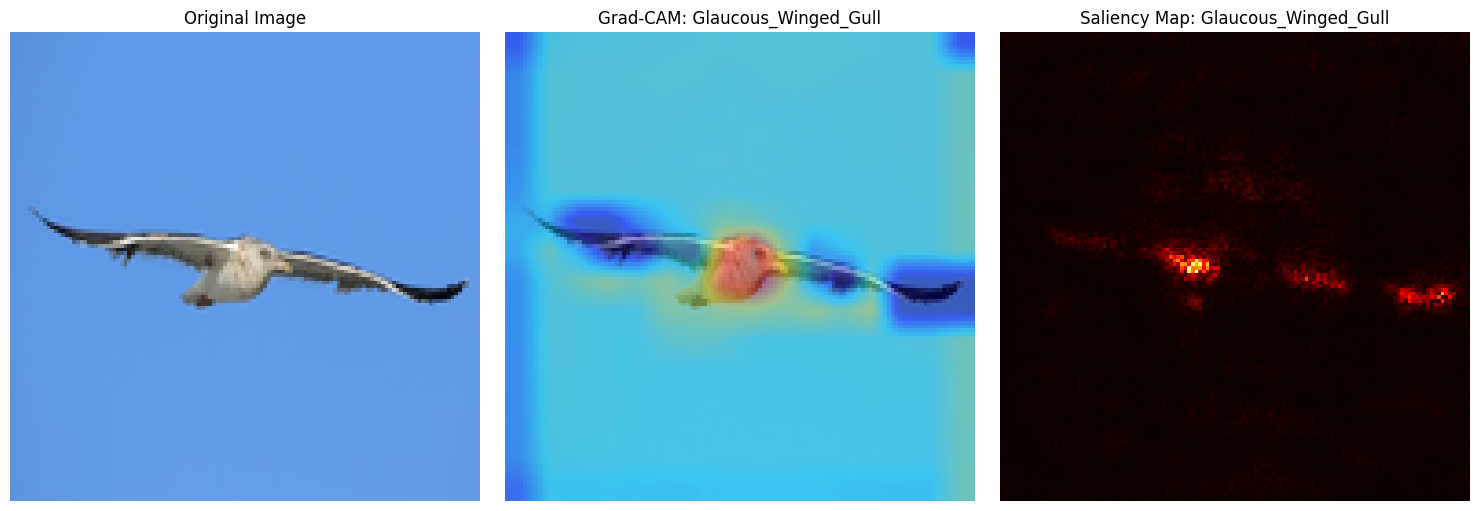

Processing: /content/drive/My Drive/FYP/Dataset/HQ2/test/Slaty_Backed_Gull/007.jpg


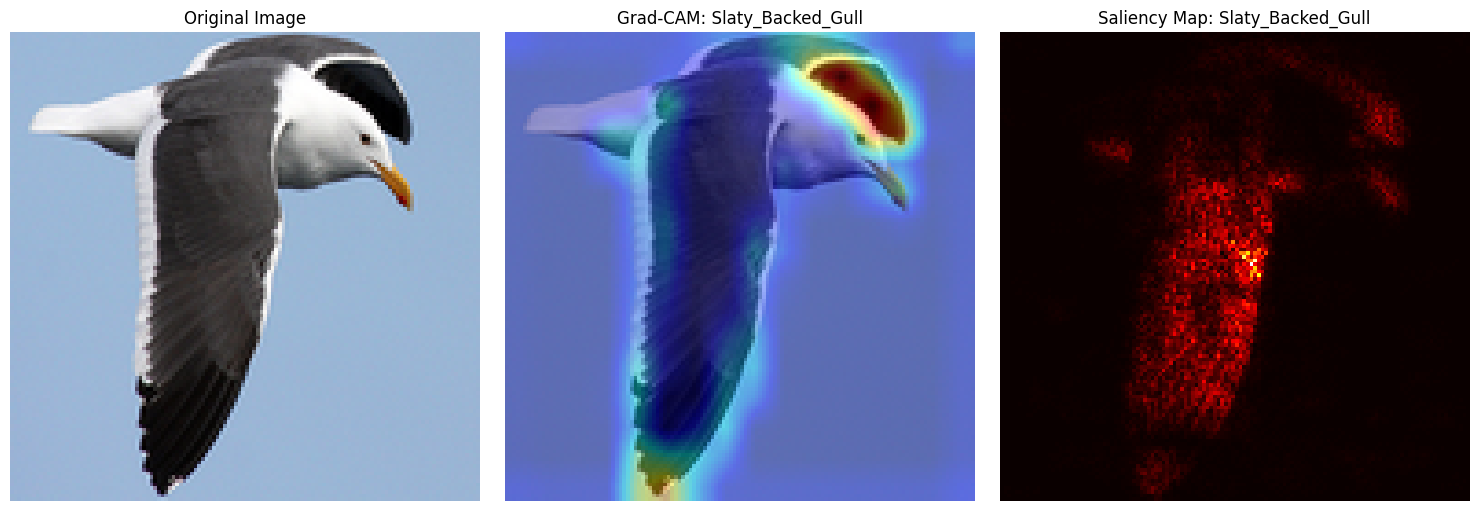

Processing: /content/drive/My Drive/FYP/Dataset/HQ2/test/Slaty_Backed_Gull/480 (3).jpeg


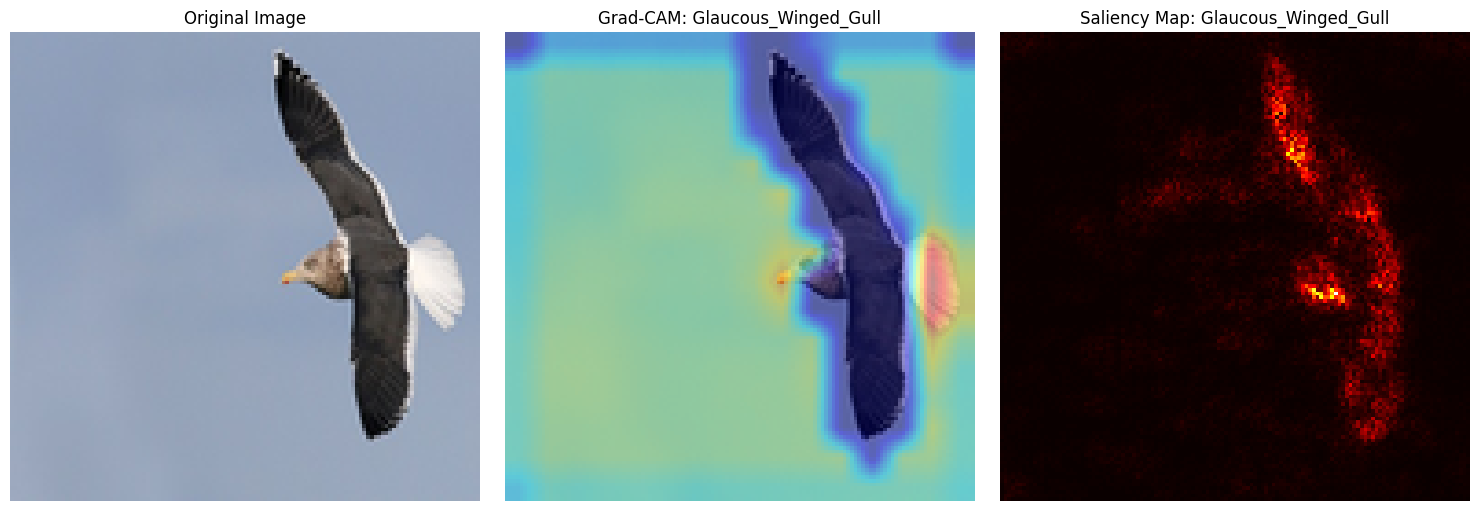

Processing: /content/drive/My Drive/FYP/Dataset/HQ2/test/Slaty_Backed_Gull/480 (32).jpeg


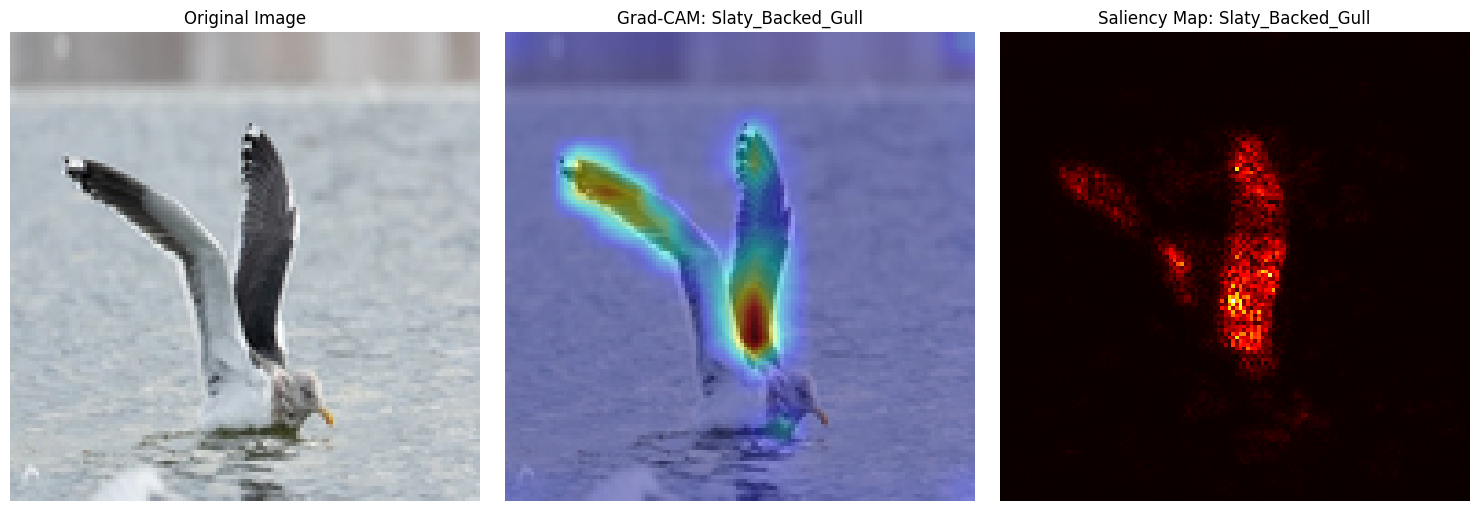

Processing: /content/drive/My Drive/FYP/Dataset/HQ2/test/Slaty_Backed_Gull/480 (9).jpeg


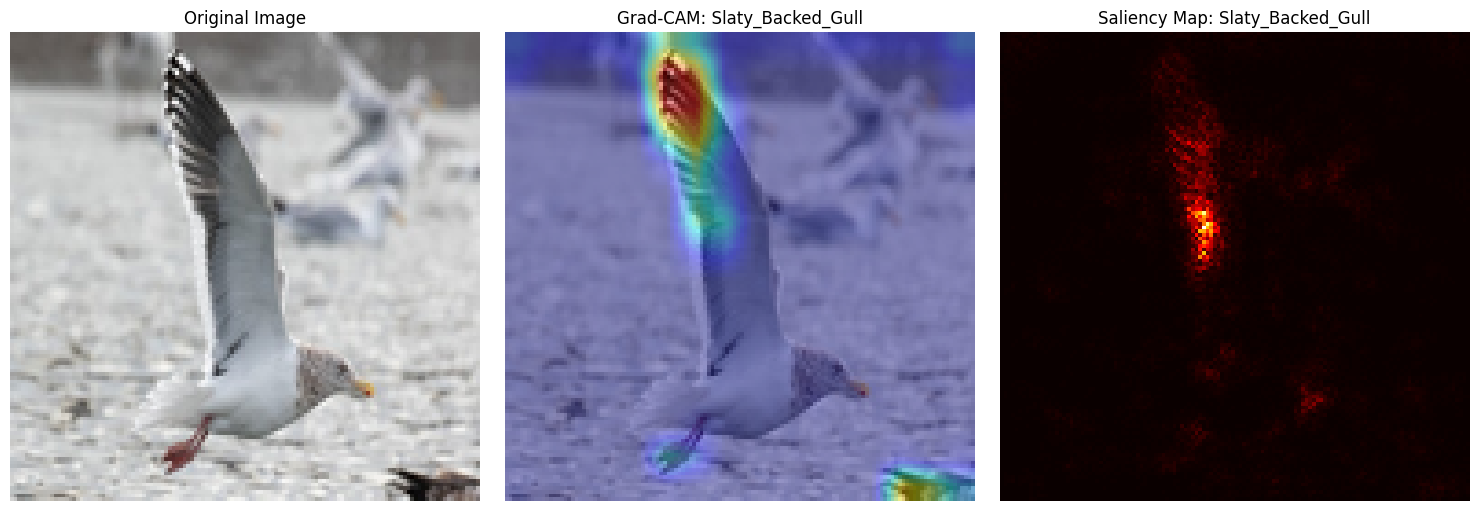

Processing: /content/drive/My Drive/FYP/Dataset/HQ2/test/Slaty_Backed_Gull/480 (53).jpeg


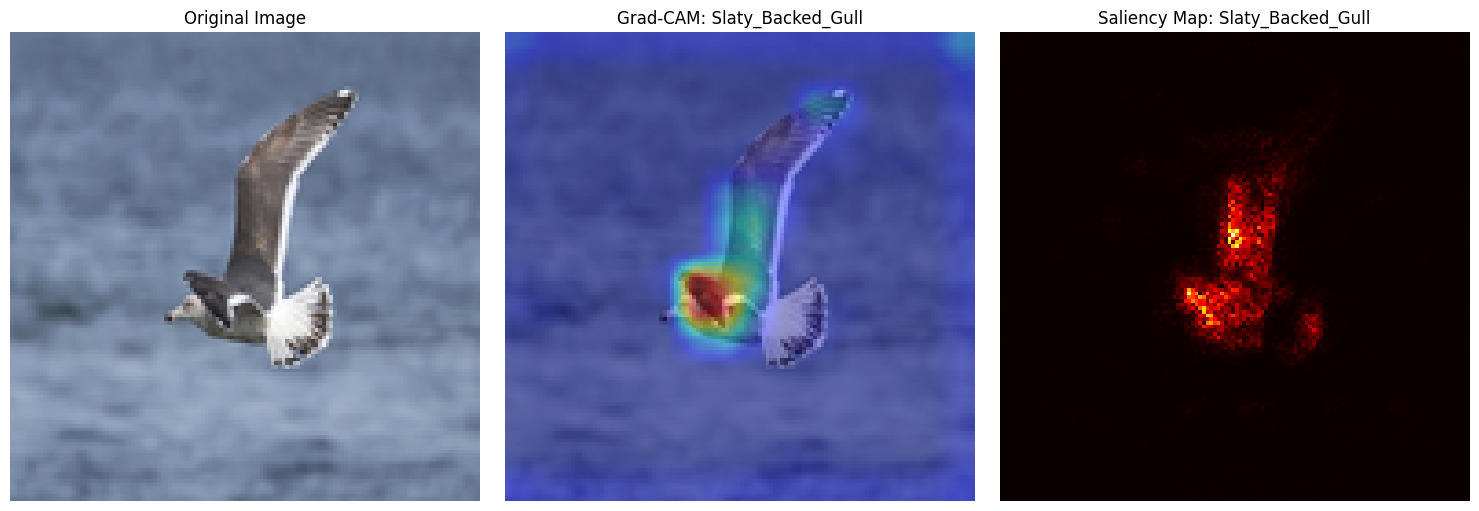

Processing: /content/drive/My Drive/FYP/Dataset/HQ2/test/Slaty_Backed_Gull/480 (29).jpeg


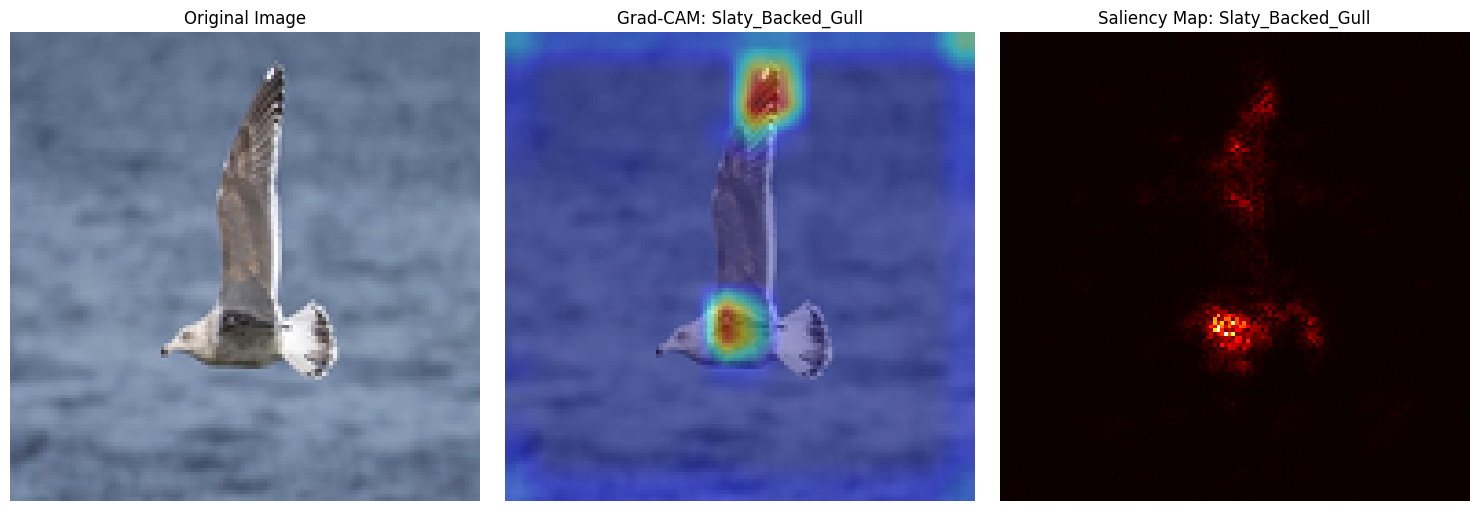

Processing: /content/drive/My Drive/FYP/Dataset/HQ2/test/Slaty_Backed_Gull/480 (19).jpeg


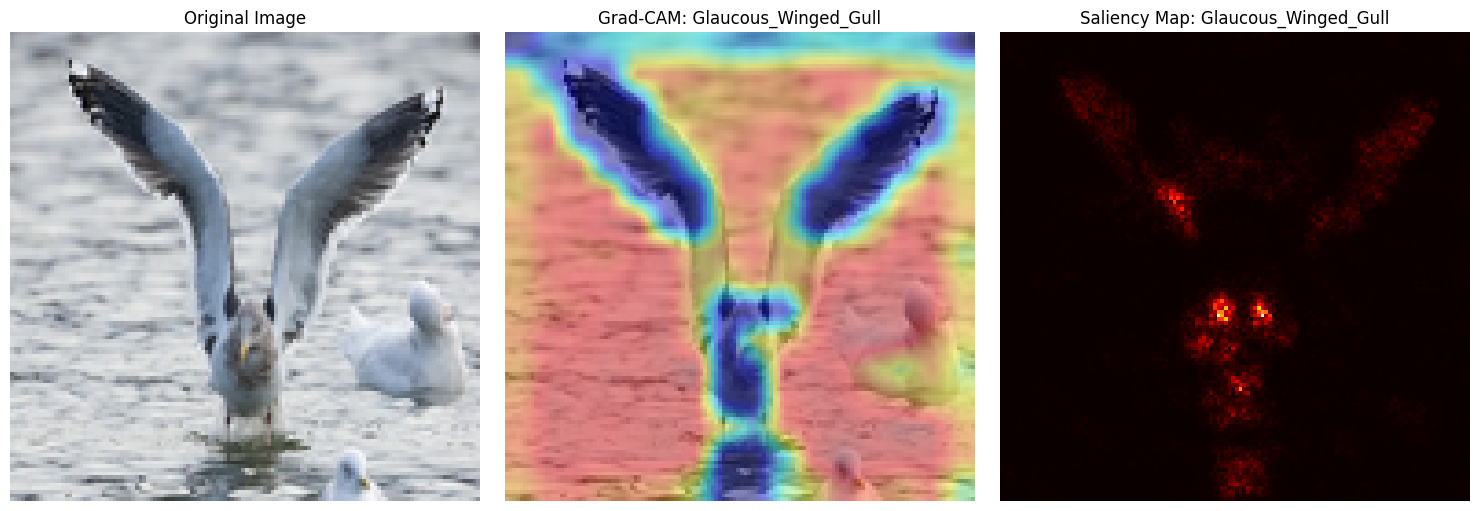

Processing: /content/drive/My Drive/FYP/Dataset/HQ2/test/Slaty_Backed_Gull/480 (21).jpeg


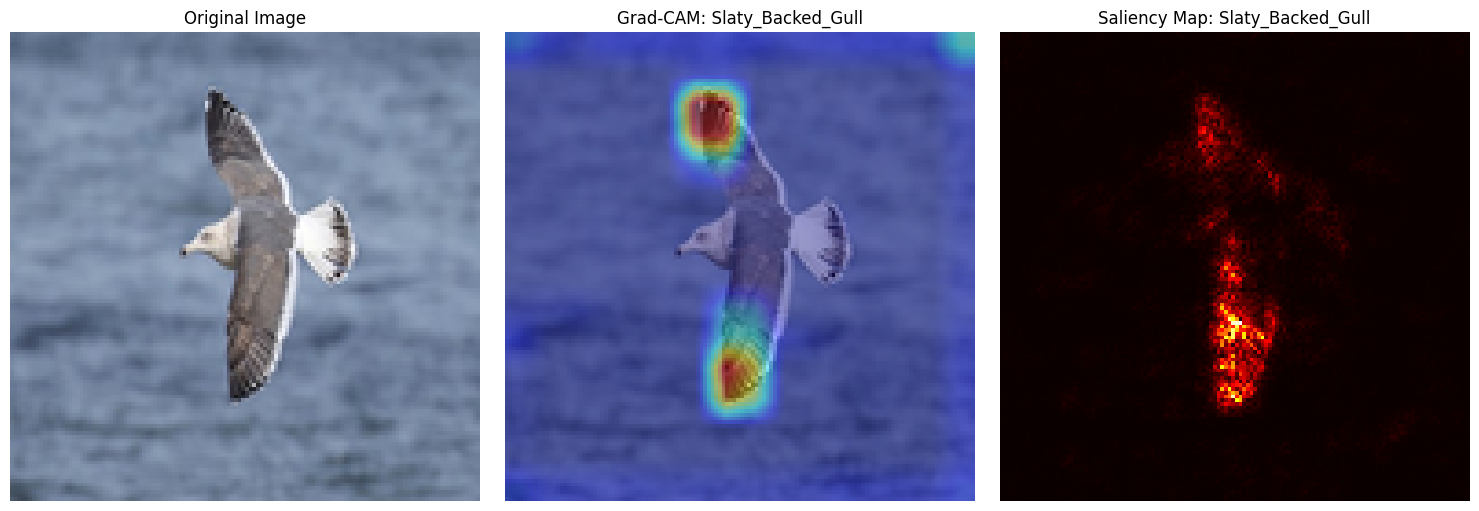

Processing: /content/drive/My Drive/FYP/Dataset/HQ2/test/Slaty_Backed_Gull/480 (33).jpeg


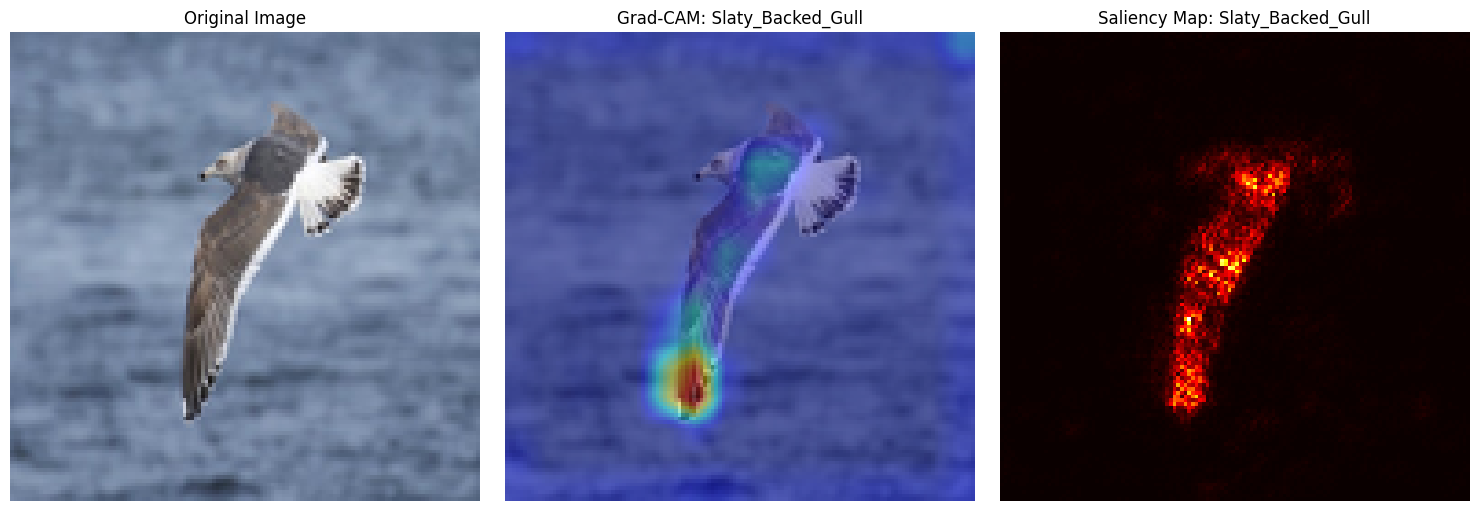

Processing: /content/drive/My Drive/FYP/Dataset/HQ2/test/Slaty_Backed_Gull/480 (6).jpeg


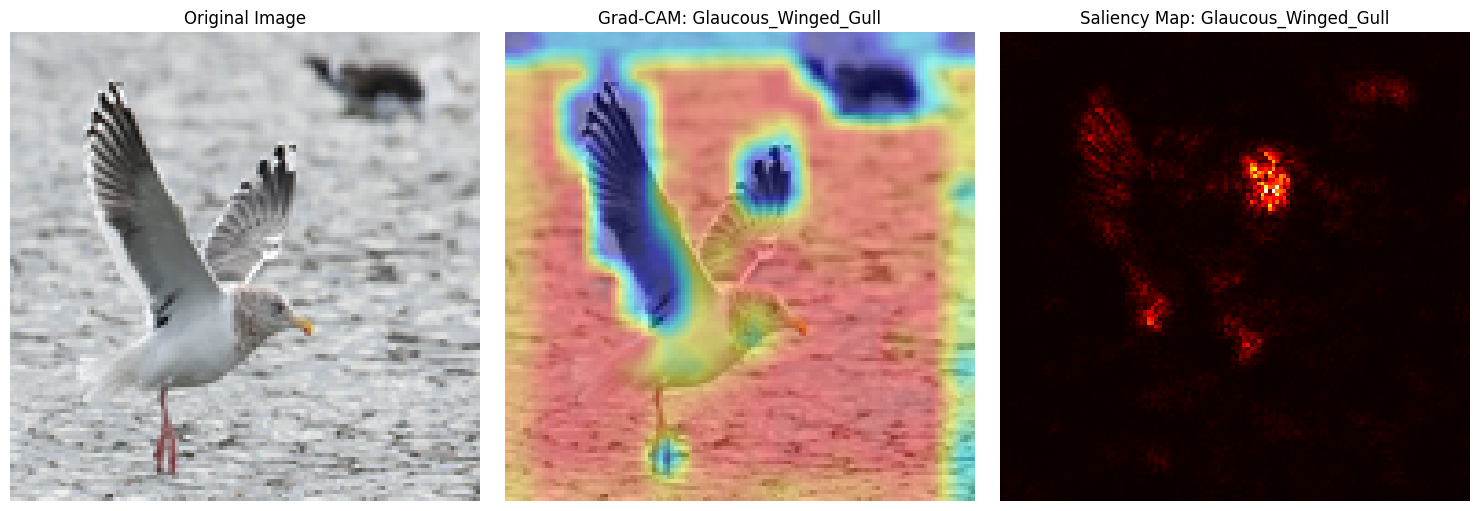

Processing: /content/drive/My Drive/FYP/Dataset/HQ2/test/Slaty_Backed_Gull/011sm.jpg


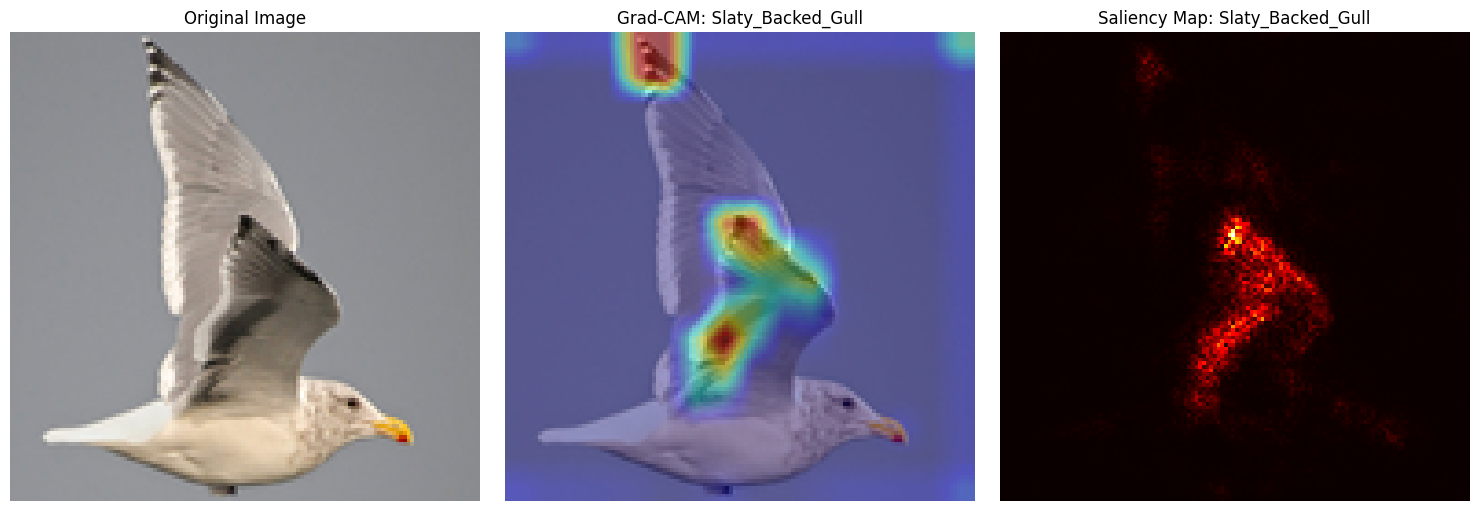

Processing: /content/drive/My Drive/FYP/Dataset/HQ2/test/Slaty_Backed_Gull/480 (45).jpeg


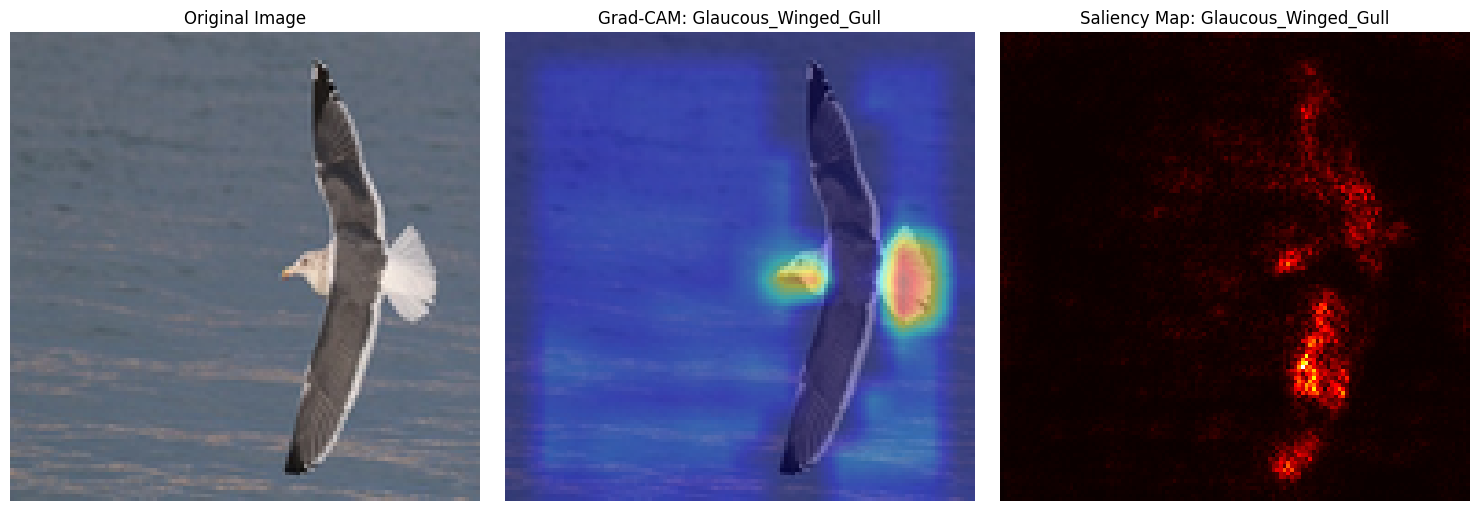

Processing: /content/drive/My Drive/FYP/Dataset/HQ2/test/Slaty_Backed_Gull/480 (40).jpeg


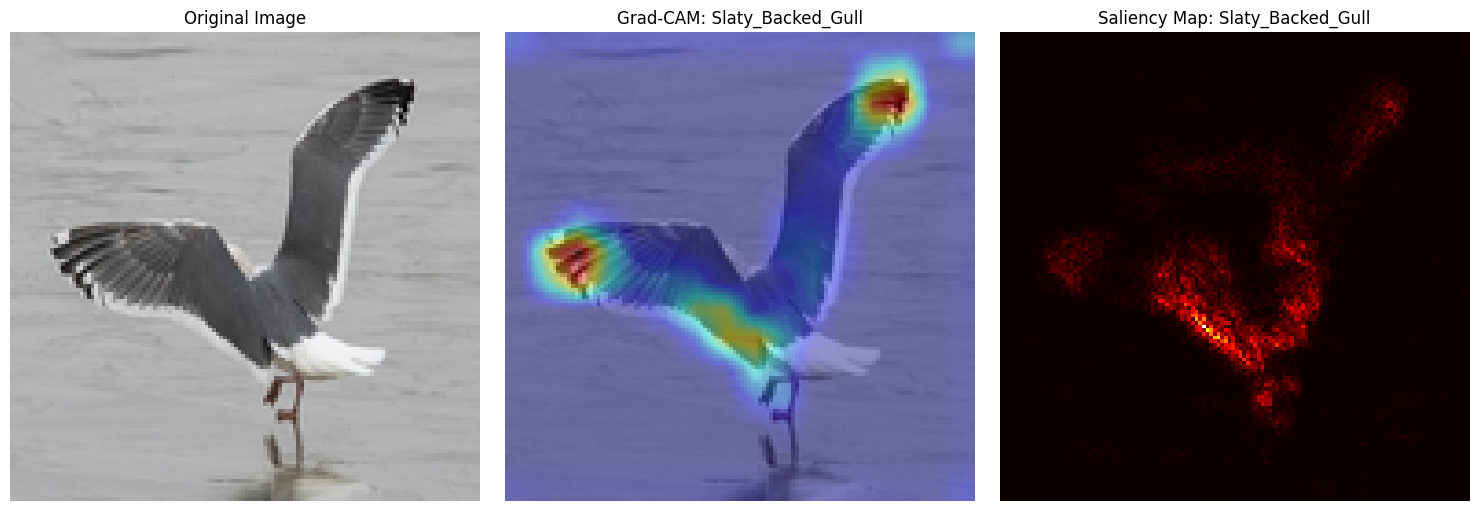

Processing: /content/drive/My Drive/FYP/Dataset/HQ2/test/Slaty_Backed_Gull/480 (7).jpeg


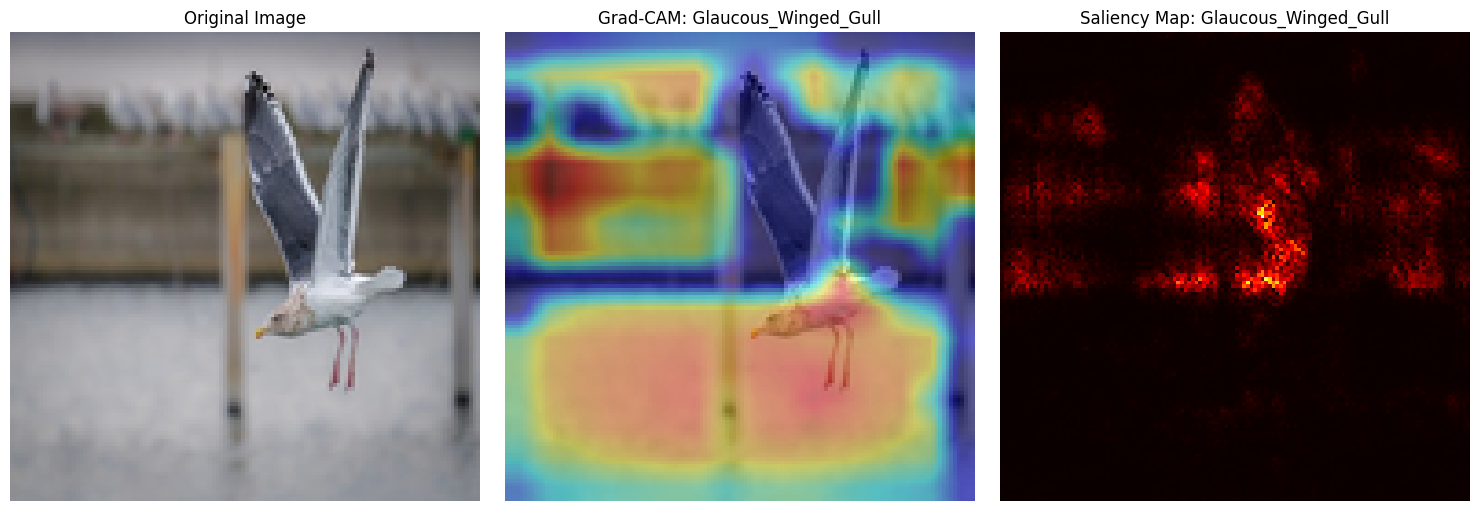

Processing: /content/drive/My Drive/FYP/Dataset/HQ2/test/Slaty_Backed_Gull/480 (54).jpeg


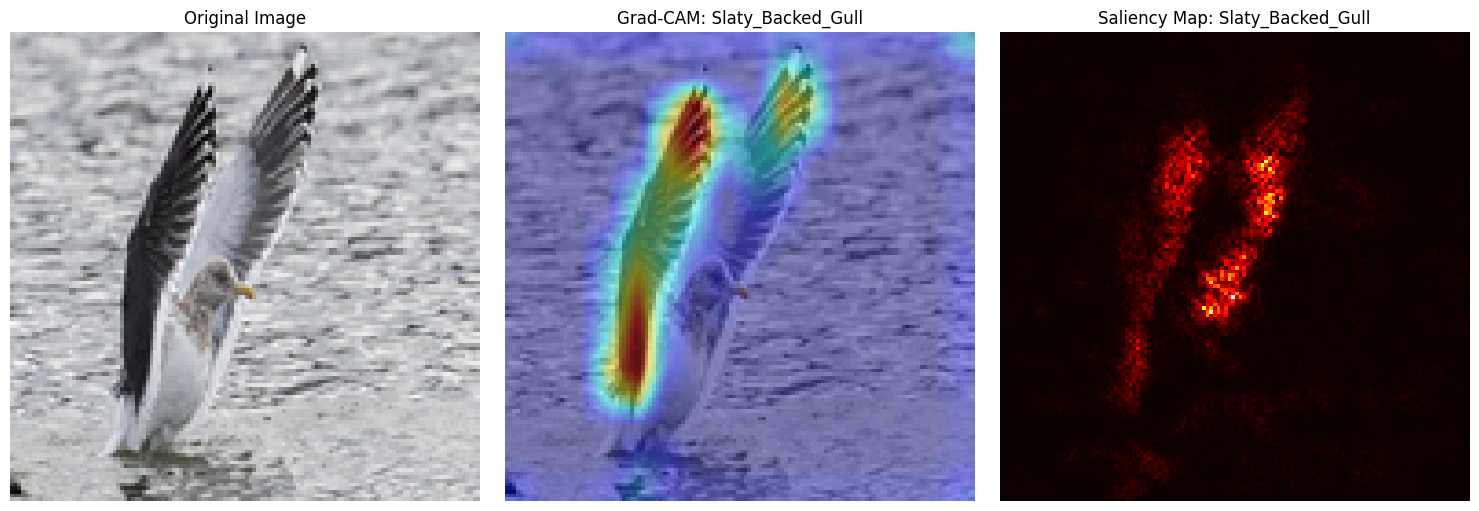

Processing: /content/drive/My Drive/FYP/Dataset/HQ2/test/Slaty_Backed_Gull/480 (41).jpeg


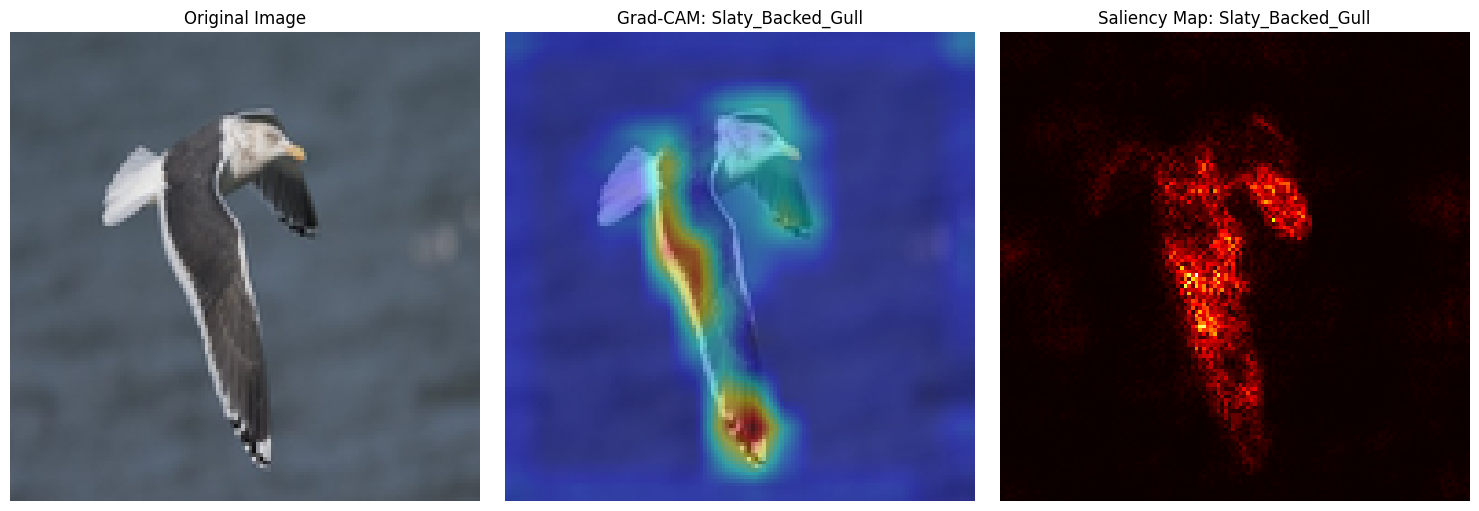

Processing: /content/drive/My Drive/FYP/Dataset/HQ2/test/Slaty_Backed_Gull/480 (15).jpeg


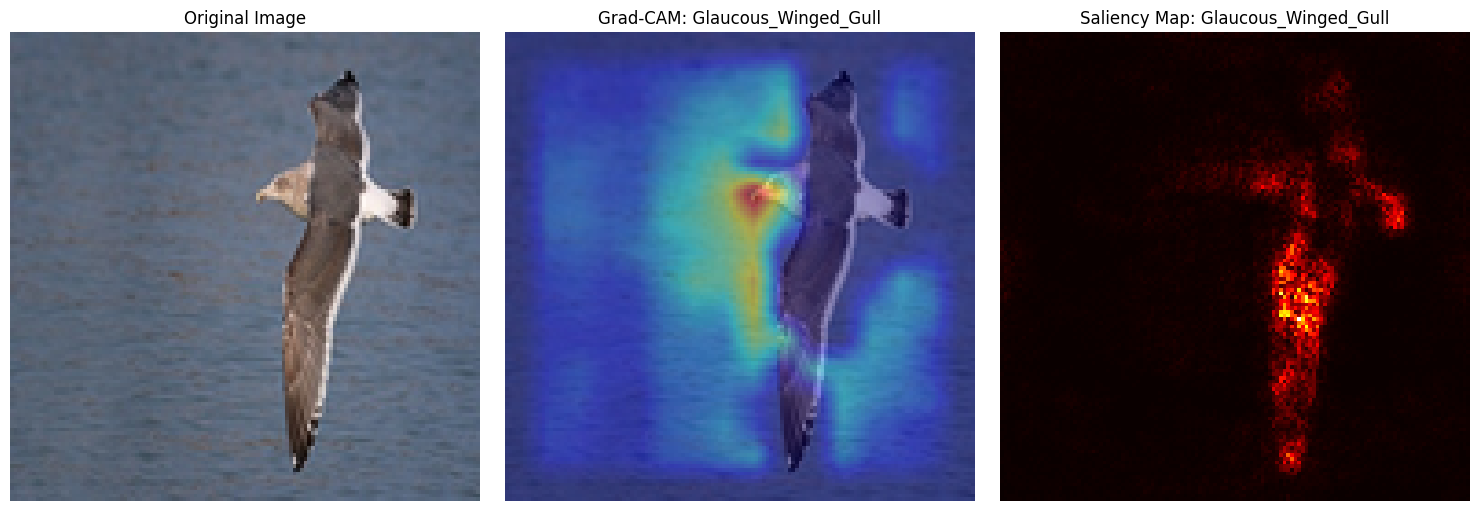

Processing: /content/drive/My Drive/FYP/Dataset/HQ2/test/Slaty_Backed_Gull/480 (1).jpeg


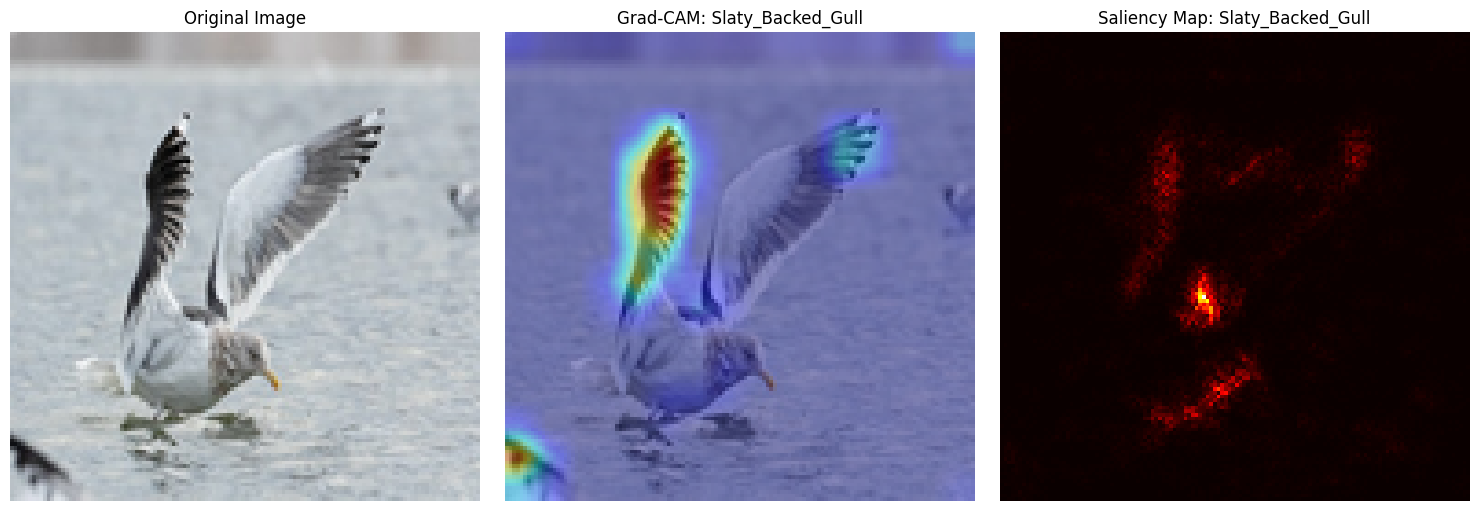

In [11]:
import os
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define model path and dataset path
checkpoint_path = '/content/drive/My Drive/FYP/CustomModel/HQ2_20241121_143157/best_model_20241121_143157.pth'
test_folder_path = '/content/drive/My Drive/FYP/Dataset/HQ2/test'  # Replace with your test folder path

# Define the SimpleCNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 2)  # Binary classification
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Load the trained model
model = SimpleCNN()
model.load_state_dict(torch.load(checkpoint_path, map_location=torch.device('cpu')))
model.eval()

# Define class names as per dataset
class_names = ['Glaucous_Winged_Gull', 'Slaty_Backed_Gull']  # Adjust based on your class order

# Define image transformation
transform = transforms.Compose([
    transforms.Resize((128, 128)),   # Resize to match training input size
    transforms.ToTensor(),
])

# Function to preprocess and load a single image
def preprocess_image(image_path):
    """Load an image and apply transformations."""
    image = Image.open(image_path).convert("RGB")
    image = transform(image)  # Apply transformations
    image = image.unsqueeze(0)  # Add batch dimension
    return image

# Grad-CAM implementation
def generate_gradcam(model, image_tensor, target_layer):
    model.eval()
    features = []
    grads = []

    # Define hooks to capture feature maps and gradients
    def save_features_hook(module, input, output):
        features.append(output)

    def save_grads_hook(module, grad_in, grad_out):
        grads.append(grad_out[0])

    # Register hooks to the target layer
    hook1 = target_layer.register_forward_hook(save_features_hook)
    hook2 = target_layer.register_backward_hook(save_grads_hook)

    # Forward pass
    output = model(image_tensor)
    predicted_class_idx = output.argmax().item()

    # Backward pass to get gradients
    model.zero_grad()
    class_loss = output[0, predicted_class_idx]
    class_loss.backward()

    # Process gradients and feature maps
    gradient = grads[0].cpu().data.numpy()[0]
    feature_map = features[0].cpu().data.numpy()[0]

    # Calculate Grad-CAM
    weights = np.mean(gradient, axis=(1, 2))  # Global average pooling of gradients
    cam = np.zeros(feature_map.shape[1:], dtype=np.float32)

    for i, w in enumerate(weights):
        cam += w * feature_map[i]

    cam = np.maximum(cam, 0)  # ReLU to remove negative values
    cam = cv2.resize(cam, (image_tensor.shape[3], image_tensor.shape[2]))  # Resize to match image dimensions
    cam -= np.min(cam)
    cam /= np.max(cam)  # Normalize between 0 and 1
    return cam, predicted_class_idx

# Saliency Map implementation
def generate_saliency_map(model, image_tensor):
    image_tensor.requires_grad_()
    output = model(image_tensor)
    predicted_class_idx = output.argmax().item()

    # Backward pass to calculate gradients
    model.zero_grad()
    output[0, predicted_class_idx].backward()

    # Calculate saliency
    saliency = image_tensor.grad.data.abs()
    saliency, _ = torch.max(saliency, dim=1)  # Take max across channels
    saliency = saliency.squeeze().cpu().numpy()

    # Normalize for visualization
    saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())
    return saliency, predicted_class_idx

# Function to visualize results
def visualize_results(image_path, gradcam, saliency, predicted_class):
    original_image = Image.open(image_path).resize((128, 128), Image.LANCZOS)
    original_image = np.array(original_image)

    # Grad-CAM heatmap overlay
    heatmap = cv2.applyColorMap(np.uint8(255 * gradcam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    gradcam_image = np.clip(0.4 * heatmap + 0.6 * original_image, 0, 255).astype(np.uint8)

    # Plot images
    plt.figure(figsize=(15, 5))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(original_image)
    plt.axis('off')

    # Grad-CAM
    plt.subplot(1, 3, 2)
    plt.title(f"Grad-CAM: {class_names[predicted_class]}")
    plt.imshow(gradcam_image)
    plt.axis('off')

    # Saliency Map
    plt.subplot(1, 3, 3)
    plt.title(f"Saliency Map: {class_names[predicted_class]}")
    plt.imshow(saliency, cmap='hot')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Process all images in the test folder
def process_test_folder(test_folder_path):
    target_layer = model.conv_layers[-1]  # Target the last convolutional layer
    for root, _, files in os.walk(test_folder_path):
        for file in files:
            image_path = os.path.join(root, file)
            print(f"Processing: {image_path}")

            # Preprocess the image
            image_tensor = preprocess_image(image_path)

            # Generate Grad-CAM and Saliency Map
            gradcam, predicted_class_idx_cam = generate_gradcam(model, image_tensor, target_layer)
            saliency, predicted_class_idx_sal = generate_saliency_map(model, image_tensor)

            # Ensure predictions from both methods match
            assert predicted_class_idx_cam == predicted_class_idx_sal, "Predicted class mismatch!"

            # Visualize results
            visualize_results(image_path, gradcam, saliency, predicted_class_idx_cam)

# Run the combined implementation on all images in the test folder
process_test_folder(test_folder_path)
